In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
groups = df.groupby(df["id"])

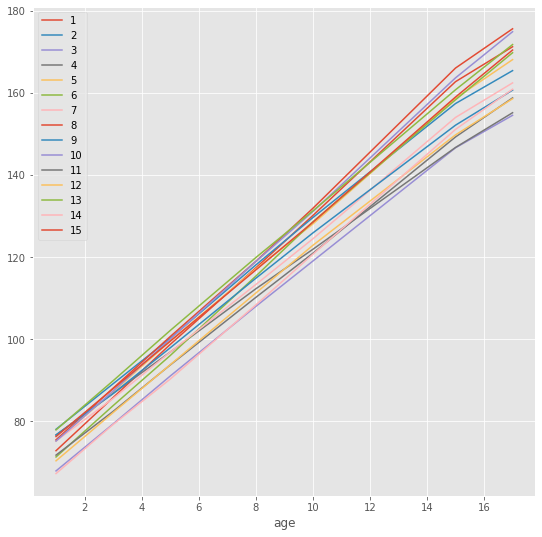

In [9]:
plt.figure(figsize=(9, 9))
for name, group in groups:
    plt.plot(group["age"], group["height"], label=name)
    
plt.xlabel("age")
plt.legend()

In [12]:
stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  } 
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}

"""

In [13]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_afb26d6f614ff30d3cddf4b7375752db NOW.


In [14]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"], "s_id":df["id"]}

In [15]:
fit = sm.sampling(data=stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [16]:
fit

Inference for Stan model: anon_model_afb26d6f614ff30d3cddf4b7375752db.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.4e-3   0.12   5.54    5.69   5.77   5.84   6.01    716    1.0
b0         68.2    0.03   0.93  66.41   67.59  68.17  68.77  70.14    875    1.0
a_id[1]    0.46  4.5e-3   0.13    0.2    0.38   0.47   0.55   0.72    856    1.0
a_id[2]   -0.19  4.6e-3   0.13  -0.47   -0.28  -0.19  -0.11   0.06    825    1.0
a_id[3]   -0.29  4.4e-3   0.13  -0.56   -0.38  -0.29  -0.21  -0.04    871    1.0
a_id[4]    -0.8  4.5e-3   0.13  -1.06   -0.88   -0.8  -0.71  -0.55    845    1.0
a_id[5]    0.09  4.5e-3   0.13  -0.19  4.8e-4   0.09   0.17   0.34    848    1.0
a_id[6]    0.41  4.5e-3   0.13   0.14    0.32   0.41   0.49   0.67    866    1.0
a_id[7]   -0.21  4.4e-3   0.13  -0.48   -0.29  -0.21  -0.12   0.05    877    1.0
a

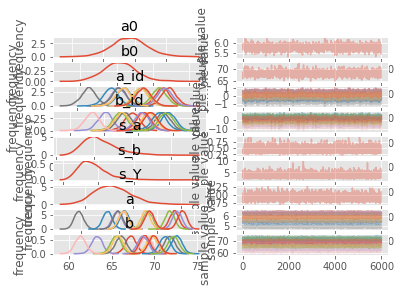

In [17]:
fig = fit.plot()

In [18]:
ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [19]:
x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:, 0]

In [20]:
df_b

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,66.587060,72.870986,79.154911,85.438837,91.722762,98.006688,104.290613,110.574539,116.858465,123.142390,129.426316,135.710241,141.994167,148.278092,154.562018,160.845944,167.129869,173.413795
1,67.492153,73.738018,79.983883,86.229747,92.475612,98.721476,104.967341,111.213205,117.459070,123.704934,129.950799,136.196664,142.442528,148.688393,154.934257,161.180122,167.425986,173.671851
2,67.445933,73.606304,79.766676,85.927048,92.087420,98.247791,104.408163,110.568535,116.728907,122.889279,129.049650,135.210022,141.370394,147.530766,153.691138,159.851509,166.011881,172.172253
3,67.114009,73.429832,79.745654,86.061476,92.377299,98.693121,105.008943,111.324766,117.640588,123.956410,130.272233,136.588055,142.903877,149.219700,155.535522,161.851344,168.167167,174.482989
4,66.962083,73.255704,79.549326,85.842947,92.136568,98.430189,104.723810,111.017432,117.311053,123.604674,129.898295,136.191916,142.485537,148.779159,155.072780,161.366401,167.660022,173.953643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,66.997404,73.285797,79.574190,85.862584,92.150977,98.439370,104.727763,111.016156,117.304549,123.592942,129.881336,136.169729,142.458122,148.746515,155.034908,161.323301,167.611694,173.900088
5996,66.608032,72.879607,79.151181,85.422755,91.694330,97.965904,104.237478,110.509053,116.780627,123.052201,129.323776,135.595350,141.866924,148.138499,154.410073,160.681648,166.953222,173.224796
5997,66.424852,72.753618,79.082383,85.411149,91.739914,98.068680,104.397445,110.726211,117.054976,123.383742,129.712507,136.041273,142.370038,148.698804,155.027569,161.356335,167.685100,174.013866
5998,67.091953,73.334639,79.577325,85.820011,92.062697,98.305382,104.548068,110.790754,117.033440,123.276126,129.518812,135.761498,142.004183,148.246869,154.489555,160.732241,166.974927,173.217613


In [21]:
low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [22]:
df_0 = groups.get_group(1)
df_0

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1
5,15,162.717327,1
6,17,171.236888,1


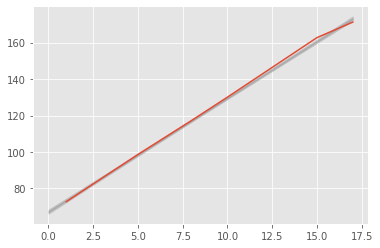

In [23]:
plt.plot(df_0["age"], df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")

共通部分として他の人のデータが使える＝データ数が増える！